# 期末大作业 使用Bert+ViT/ResNet

In [1]:
%pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
import cv2
import random
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## 数据读取与预处理

In [3]:
all_posters_filename = os.listdir('./poster')
all_posters_index = sorted([int(x[:-4]) for x in all_posters_filename])
all_posters_filename = [f'{i}.jpg' for i in all_posters_index]
df_movie_info = pd.read_csv('info.csv', index_col=0).loc[all_posters_index, ['name', 'intro']]
df_movie_info.head(5)

name  \
id                                        
1                     Toy Story (1995)    
2                       Jumanji (1995)    
3              Grumpier Old Men (1995)    
4             Waiting to Exhale (1995)    
5   Father of the Bride Part II (1995)    

                                                intro  
id                                                     
1   A cowboy doll is profoundly threatened and jea...  
2   When two kids find and play a magical board ga...  
3   John and Max resolve to save their beloved bai...  
4   Based on Terry McMillan's novel, this film fol...  
5   George Banks must deal not only with the pregn...

In [4]:
movie_intros = df_movie_info.loc[:, 'intro'].tolist()
movie_names = df_movie_info.loc[:, 'name'].tolist()

Doctor Dolittle (1998) 
A doctor discovers that he can communicate with animals.


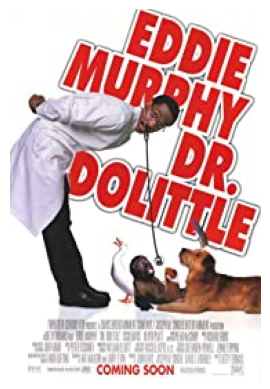

In [5]:
# 检查预处理完成后海报和简介数据的索引是否能够对应
index_for_test = random.randint(0, len(all_posters_index) - 1)

print(movie_names[index_for_test])
print(movie_intros[index_for_test])

poster = cv2.imread(f'./poster/{all_posters_filename[index_for_test]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()

## 训练集划分

In [6]:
with open('train.txt', 'r') as f:
    lines = f.readlines()
    train_idx = [int(line.strip()) for line in lines]

posters_train = [all_posters_filename[i] for i in train_idx]
posters_test = all_posters_filename.copy()
intros_train = [movie_intros[i] for i in train_idx]
intros_test = movie_intros.copy()

# Here elements in posters_train and posters_test are actually filenames, not vectors
print(len(posters_train), len(posters_test), len(intros_train), len(intros_test))

1762 2938 1762 2938


## 搭建pytorch数据集

以下只是一种可能的写法
- 如果之前已经完成了对海报和简介数据的预处理工作，那么就可以不需要这里的`process_poster`和`process_intro`函数
- 如果之前已经将海报数据全部读入，那么就无需再在`Dataset`类中写一次读取图片的操作（对于小数据集可以这样做，但是对于大型的数据集，全部读进来通常是存不下的，因此更推荐在继承的`Dataset`或者`DataLoader`中实现按需读取和预处理）
- ......

In [7]:
import torchvision.transforms as transforms
from torchvision import models
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from transformers import ViTModel, ViTFeatureExtractor

cache_dir = './hub'
class MovieLensDataset(Dataset):
    def __init__(self, data_root, posters, intros, **kwargs):
        self.data_root = data_root
        self.posters = posters
        self.intros = intros
        self.image_processor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224',  cache_dir=cache_dir)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=cache_dir)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def __len__(self):
        return len(self.posters)
    
    def process_poster(self, path):
        poster = cv2.imread(path)
        poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
        # poster = self.transform(poster)
        poster = self.image_processor(images=poster, return_tensors='pt')['pixel_values'].squeeze(0)
        return poster
    
    
    def process_intro(self, intro):
        tokens = self.tokenizer(intro, padding='max_length', max_length=128, truncation=True, return_tensors='pt')
        return tokens['input_ids'].squeeze(0), tokens['attention_mask'].squeeze(0)
    
    def __getitem__(self, index):
        poster = self.process_poster(os.path.join(self.data_root, self.posters[index]))
        input_ids, attention_mask = self.process_intro(self.intros[index])
        return poster, input_ids, attention_mask


data_root = './poster'
dataset_train = MovieLensDataset(
    data_root=data_root,
    posters=posters_train,
    intros=intros_train,
)
dataset_test = MovieLensDataset(
    data_root=data_root,
    posters=posters_test,
    intros=intros_test,
)

/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [8]:
train_dataloader = DataLoader(dataset_train, batch_size=8, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=8)

In [9]:
import numpy as np

# 迭代DataLoader并查看数据
for posters, input_ids, attention_mask in train_dataloader:
    print("Intros:", input_ids)  # 打印简介文本
    print("intros shape:", input_ids.shape)
    print("Posters shape:", posters.shape)  # 打印海报张量的形状
    print("posters: ", posters)
    # 只查看一个批次
    break

Intros: tensor([[  101,  1037,  2402,  ...,     0,     0,     0],
        [  101,  2006,  2049,  ...,     0,     0,     0],
        [  101,  2048,  2814,  ...,     0,     0,     0],
        ...,
        [  101,  2043,  1996,  ...,     0,     0,     0],
        [  101,  1037, 23170,  ...,     0,     0,     0],
        [  101,  1037,  8386,  ...,     0,     0,     0]])
intros shape: torch.Size([8, 128])
Posters shape: torch.Size([8, 3, 224, 224])
posters:  tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -0.9843,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-0.9686, -0.9765, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
          [-0.9765, 

## 定义模型

In [10]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_distances


class MyModel(nn.Module):
    def __init__(self, hidden_dim):
        super(MyModel, self).__init__()
        self.image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224', cache_dir=cache_dir)
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased', cache_dir=cache_dir)
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.image_fc = nn.Sequential(
            nn.Linear(2048, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.text_fc = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.vit_to_resnet = nn.Linear(self.image_encoder.config.hidden_size, 3 * 224 * 224)

    def forward(self, images, input_ids, attention_mask):
        vit_features = self.image_encoder(pixel_values=images).pooler_output
        resnet_input = self.vit_to_resnet(vit_features)
        resnet_input = resnet_input.view(vit_features.size(0), 3, 224, 224)
        image_features = self.resnet(resnet_input)
        image_features = self.image_fc(image_features)
        text_features = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_features = self.text_fc(text_features)
        return image_features, text_features
    
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / temperature))

    def forward(self, image_features, text_features):
        batch_size = image_features.size(0)
        image_features = nn.functional.normalize(image_features, dim=1)
        text_features = nn.functional.normalize(text_features, dim=1)
        labels = torch.arange(batch_size).long().to(image_features.device)
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * torch.matmul(image_features, text_features.T)
        logits_per_text = logit_scale * torch.matmul(text_features, image_features.T)
        loss_i2t = nn.CrossEntropyLoss()(logits_per_image, labels)
        loss_t2i = nn.CrossEntropyLoss()(logits_per_text, labels)
        return (loss_i2t + loss_t2i) / 2
    
def compute_distance_matrix(image_features, text_features):
    image_features = nn.functional.normalize(image_features, dim=1)
    text_features = nn.functional.normalize(text_features, dim=1)
    distance_matrix = cosine_distances(image_features.detach().cpu().numpy(), text_features.detach().cpu().numpy())
    # print(distance_matrix.shape)
    return torch.tensor(distance_matrix, device=image_features.device)

def get_acc(D, ratio=0.05, dim=1):
    '''
    Calculate the accuracy based on the top-k nearest neighbors in the distance matrix.

    Parameters:
    D : torch.Tensor
        The distance matrix with shape (N, N), where 
        D[i, j] represents the distance between poster[i] and intro[j].
    ratio : float
        A float in the range (0, 1) that determines the proportion of nearest neighbors to consider. 
    dim : int
        The dimension along which to compute the top-k neighbors. 
        Use dim=1 for top-k intros for each poster, dim=0 for the top-k posters for each intro.
    '''

    total_samples = len(D)
    k = int(ratio * total_samples)

    _, topk_indices = D.topk(k, dim=dim, largest=False)
    if dim == 0:
        topk_indices = topk_indices.T
    
    correct_matches = 0
    for i in range(total_samples):
        if i in topk_indices[i]:
            correct_matches += 1
    accuracy = correct_matches / total_samples
    return accuracy

## 模型训练

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
hidden_dim = 256  # 隐藏层维度

model = MyModel(hidden_dim).to(device)
print(model)
criterion = NTXentLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

num_epochs = 70
best_acc = 0.0
best_model_path = './bestmodel_vitresnet.pth'
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for posters, input_ids, attention_mask in train_dataloader:
        posters, input_ids, attention_mask = posters.to(device), input_ids.to(device), attention_mask.to(device)
        
        image_features, text_features = model(posters, input_ids, attention_mask)
        
        loss = criterion(image_features, text_features)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    scheduler.step(epoch_loss / len(train_dataloader))
    
    # 计算距离矩阵和准确率
    model.eval()
    all_image_features = []
    all_text_features = []
    with torch.no_grad():
        for posters, input_ids, attention_mask in test_dataloader:
            posters, input_ids, attention_mask = posters.to(device), input_ids.to(device), attention_mask.to(device)
            image_features, text_features = model(posters, input_ids, attention_mask)
            all_image_features.append(image_features)
            all_text_features.append(text_features)
    
    # 拼接所有特征
    all_image_features = torch.cat(all_image_features, dim=0)
    # print(all_image_features.shape)
    all_text_features = torch.cat(all_text_features, dim=0)
    # print(all_text_features.shape)
    
    # 计算距离矩阵
    distance_matrix = compute_distance_matrix(all_image_features, all_text_features)
    acc_dim0 = get_acc(distance_matrix, ratio=0.05, dim=0)
    acc_dim1 = get_acc(distance_matrix, ratio=0.05, dim=1)
    
    avg_acc = (acc_dim0 + acc_dim1) / 2
    
    if avg_acc > best_acc:
        best_acc = avg_acc
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with accuracy: {best_acc * 100:.2f}%')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}, Accuracy Dim 0: {acc_dim0 * 100:.2f}%, Accuracy Dim 1: {acc_dim1 * 100:.2f}%')
print("Training finished!")

cuda


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/DATA/sqf/Miniconda/envs/gspl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyModel(
  (image_encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

## 模型测试

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dim = 256
model = MyModel(hidden_dim).to(device)
best_model_path = './bestmodel_vitresnet.pth'
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_image_features = []
all_text_features = []
with torch.no_grad():
    for posters, input_ids, attention_mask in test_dataloader:
        posters, input_ids, attention_mask = posters.to(device), input_ids.to(device), attention_mask.to(device)
        image_features, text_features = model(posters, input_ids, attention_mask)
        all_image_features.append(image_features)
        all_text_features.append(text_features)

all_image_features = torch.cat(all_image_features, dim=0)
all_text_features = torch.cat(all_text_features, dim=0)

distance_matrix = compute_distance_matrix(all_image_features, all_text_features)
acc_dim0 = get_acc(distance_matrix, ratio=0.05, dim=0)
acc_dim1 = get_acc(distance_matrix, ratio=0.05, dim=1)
sum_acc = acc_dim0 + acc_dim1
print(f'The acc of the best model is: acc_dim0: {acc_dim0} acc_dim1: {acc_dim1} sum: {sum_acc}')

The acc of the best model is: acc_dim0: 0.6718856364874064 acc_dim1: 0.6715452688904017 sum: 1.343430905377808


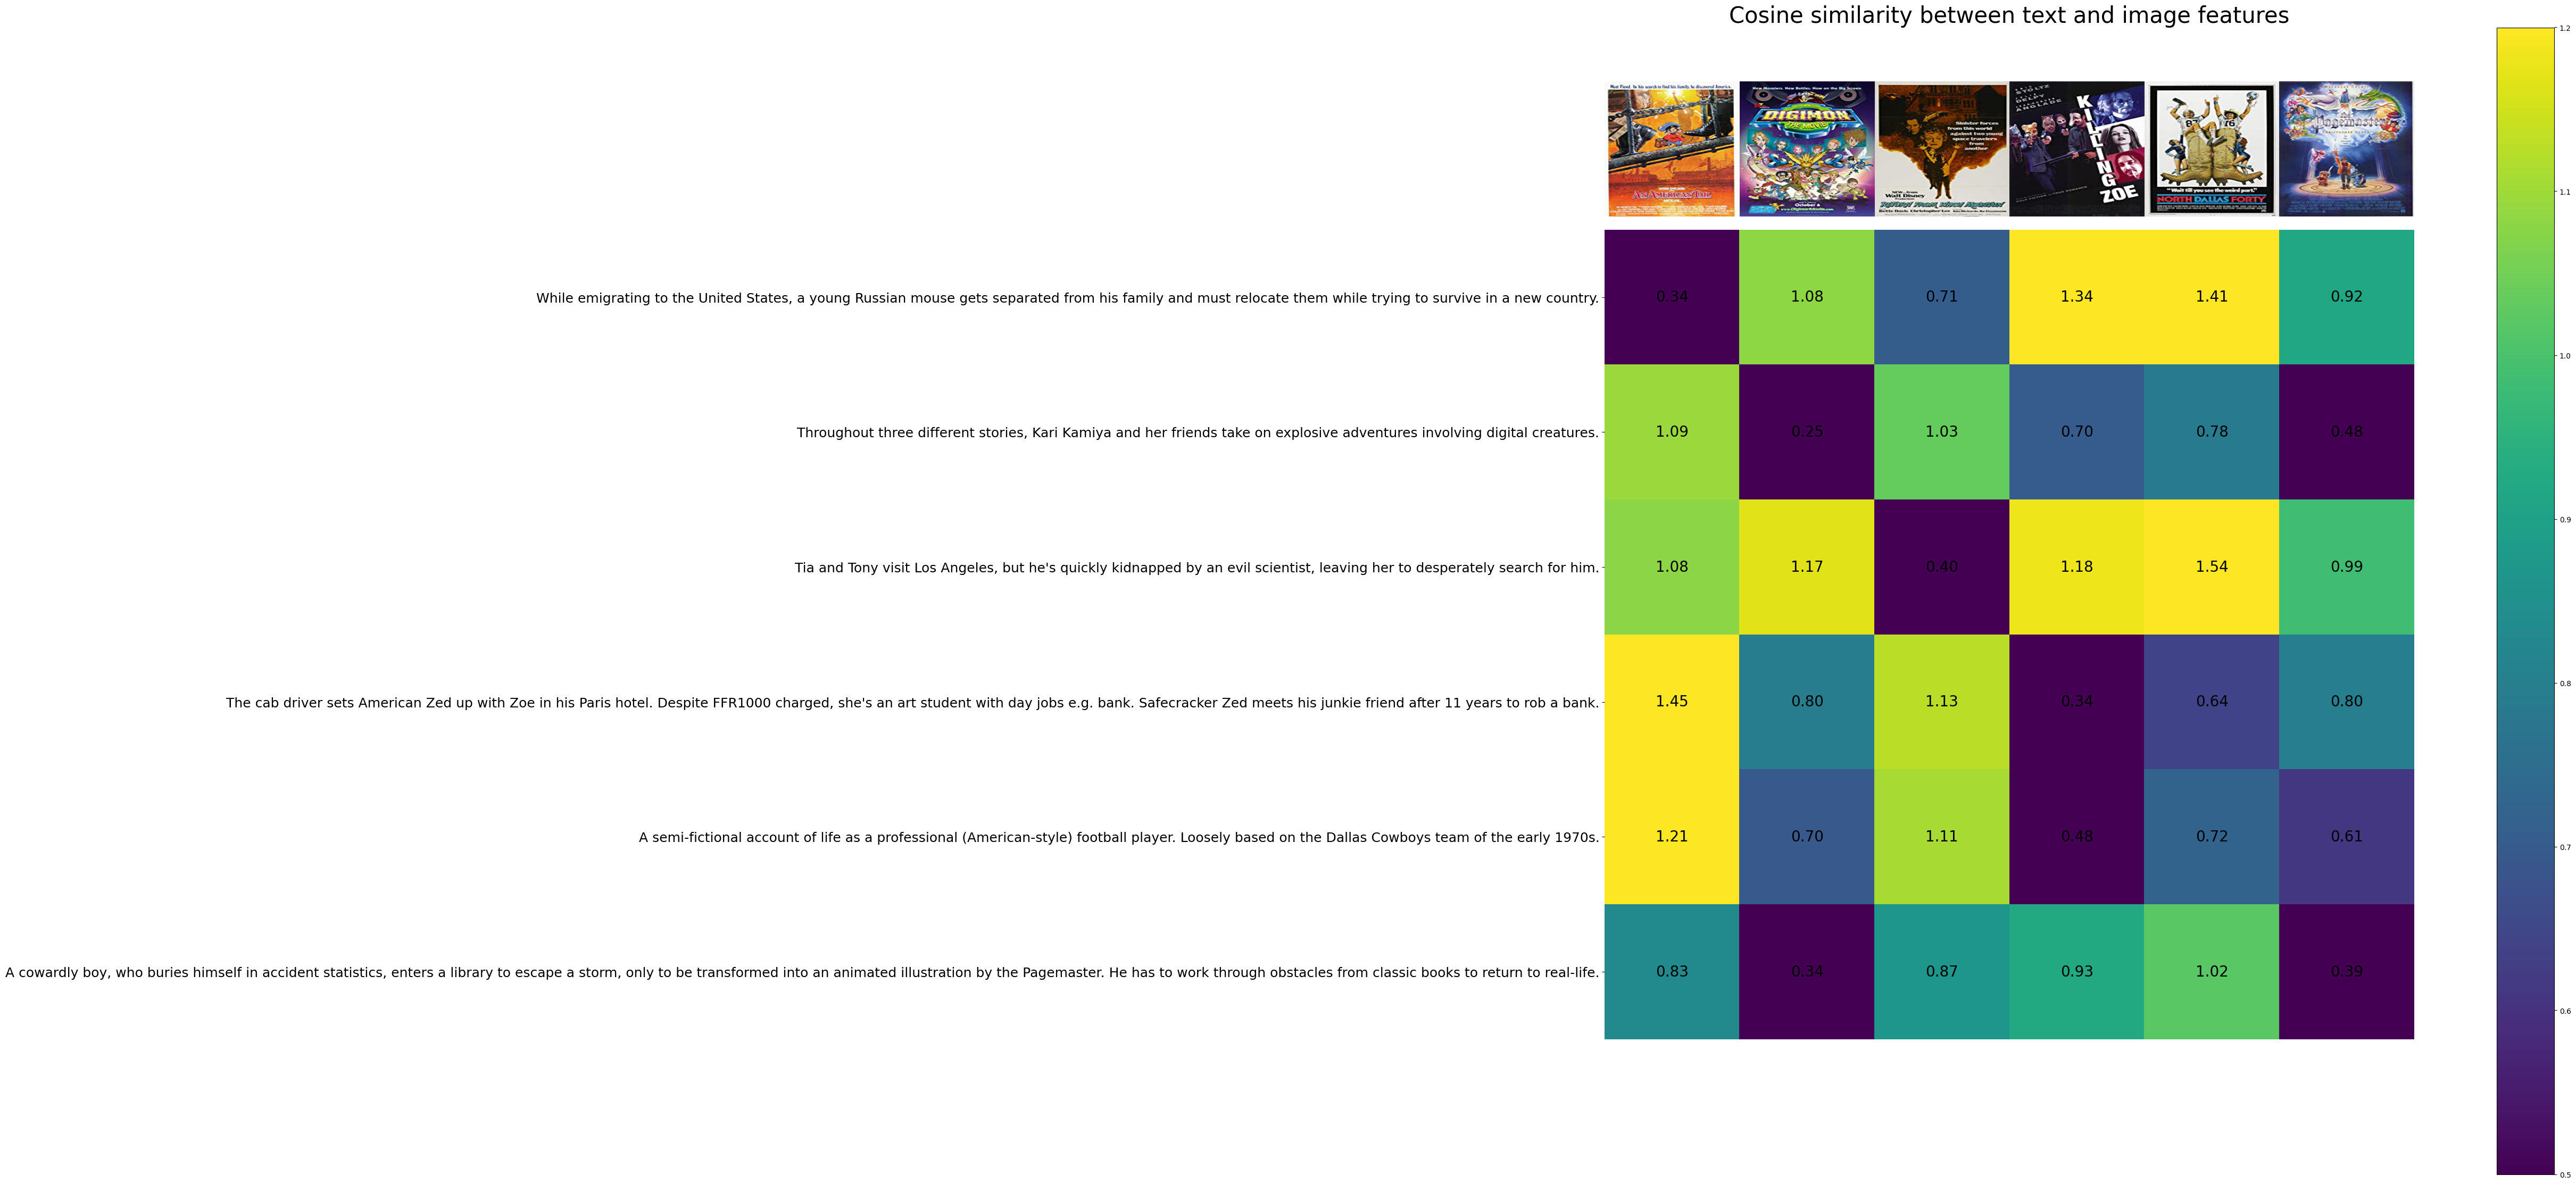

Movie Name: An American Tail (1986) 
Movie Intro: While emigrating to the United States, a young Russian mouse gets separated from his family and must relocate them while trying to survive in a new country.


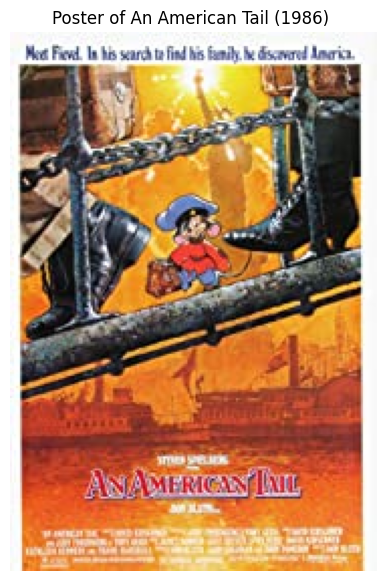

Movie Name: Digimon: The Movie (2000) 
Movie Intro: Throughout three different stories, Kari Kamiya and her friends take on explosive adventures involving digital creatures.


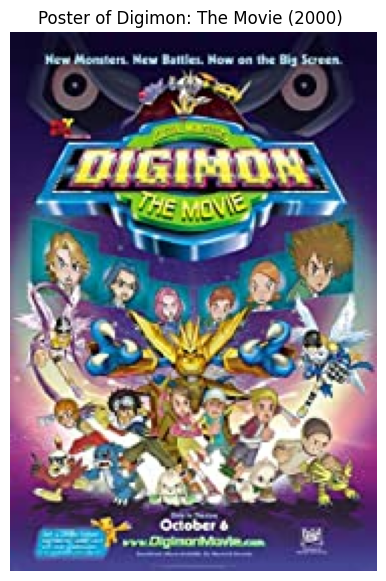

Movie Name: Return from Witch Mountain (1978) 
Movie Intro: Tia and Tony visit Los Angeles, but he's quickly kidnapped by an evil scientist, leaving her to desperately search for him.


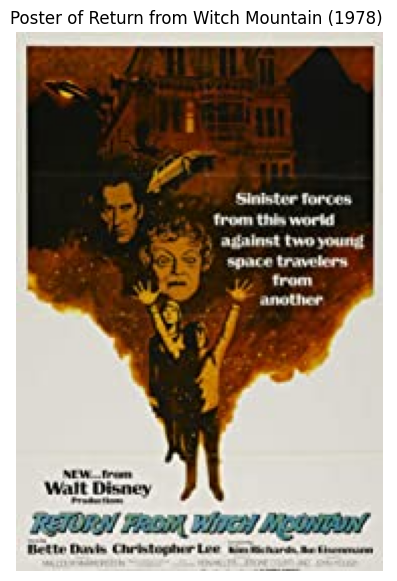

Movie Name: Killing Zoe (1993) 
Movie Intro: The cab driver sets American Zed up with Zoe in his Paris hotel. Despite FFR1000 charged, she's an art student with day jobs e.g. bank. Safecracker Zed meets his junkie friend after 11 years to rob a bank.


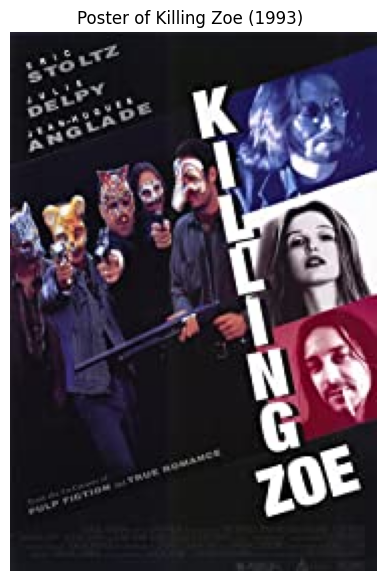

Movie Name: North Dallas Forty (1979) 
Movie Intro: A semi-fictional account of life as a professional (American-style) football player. Loosely based on the Dallas Cowboys team of the early 1970s.


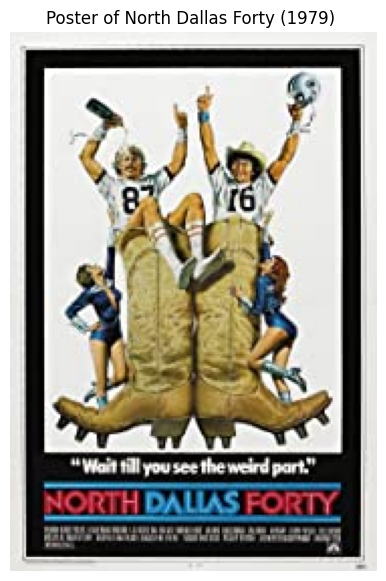

Movie Name: The Pagemaster (1994) 
Movie Intro: A cowardly boy, who buries himself in accident statistics, enters a library to escape a storm, only to be transformed into an animated illustration by the Pagemaster. He has to work through obstacles from classic books to return to real-life.


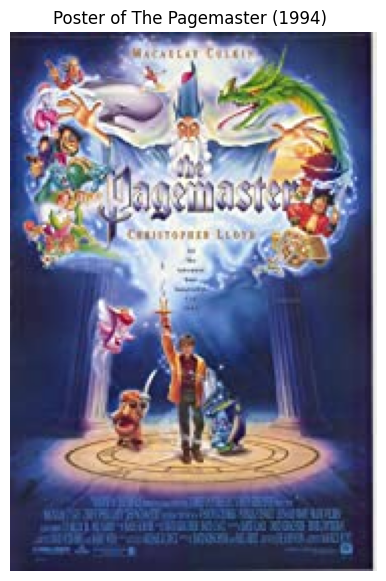

In [17]:
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

distance_matrix_np = distance_matrix.cpu().numpy()

selected_indices = random.sample(range(len(movie_names)), 6)
sub_distance_matrix = distance_matrix_np[selected_indices][:, selected_indices]

original_images = []
for index in selected_indices:
    filename = f'./poster/{all_posters_filename[index]}'
    image = Image.open(os.path.join(filename)).convert("RGB")
    original_images.append(image)

count = len(selected_indices)
texts = [movie_intros[i] for i in selected_indices]
plt.figure(figsize=(40, 28))
plt.imshow(sub_distance_matrix, vmin=0.5, vmax=1.2)
plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(sub_distance_matrix.shape[1]):
    for y in range(sub_distance_matrix.shape[0]):
        plt.text(x, y, f"{sub_distance_matrix[y, x]:.2f}", ha="center", va="center", size=20)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=30)
plt.show()

# 显示对应的海报图片和简介
for index in selected_indices:
    print("Movie Name:", movie_names[index])
    print("Movie Intro:", movie_intros[index])

    # 读取并显示对应的海报
    poster = cv2.imread(f'./poster/{all_posters_filename[index]}')
    poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 7))
    plt.imshow(poster)
    plt.axis('off')
    plt.title(f"Poster of {movie_names[index]}")
    plt.show()

movie name: The Pillow Book (1996) 
movie intro: A woman with a body writing fetish seeks to find a combined lover and calligrapher.


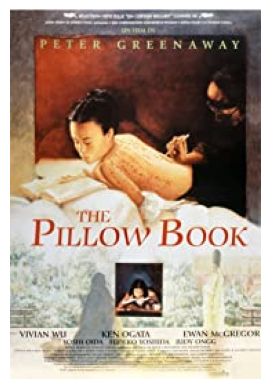

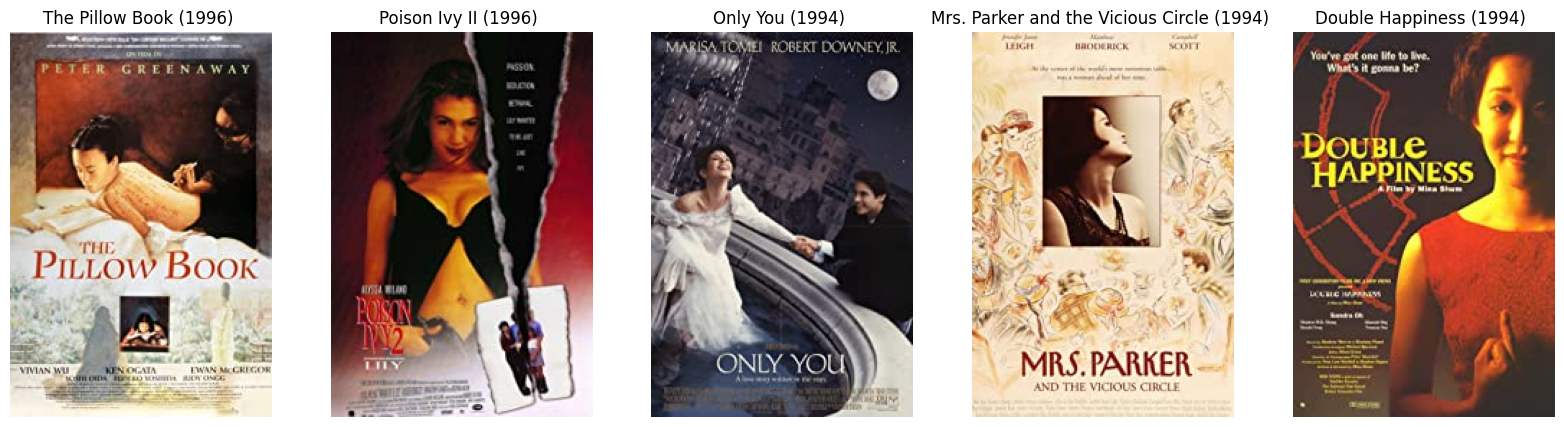

In [18]:
index_1 = random.randint(0, len(movie_names))
total_samples = len(distance_matrix)
_, topk_indices_1 = distance_matrix.topk(5, dim=1, largest=False)
print(f'movie name: {movie_names[index_1]}')
print(f'movie intro: {movie_intros[index_1]}')
poster = cv2.imread(f'./poster/{all_posters_filename[index_1]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in zip(topk_indices_1[index_1, :], axes):
    i = i.item()  # 将张量转换为整数
    poster = cv2.imread(f'./poster/{all_posters_filename[i]}')
    poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
    ax.imshow(poster)
    ax.axis('off')
    ax.set_title(movie_names[i])

plt.show()

movie name: Can't Hardly Wait (1998) 
movie intro: Multicharacter teenage comedy about high school graduates with different agenda of life on graduation night.


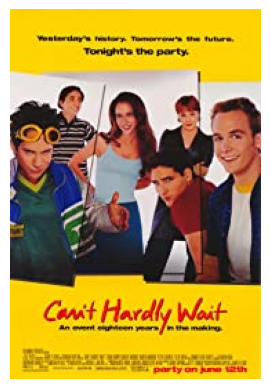

Three of the most popular girls at Reagan High accidentally kill the prom queen with a jawbreaker when a kidnapping goes horribly wrong.
Multicharacter teenage comedy about high school graduates with different agenda of life on graduation night.
A tenderly romantic coming-of-age story as two boys in a British school fall in love.
A spoof on Lethal Weapon (1987), other movies, TV commercials etc. 2 unlike LA cops investigate a cocaine in girl scout cookies case.
Comedy about a widow's post-traumatic obsession with a soap star.


In [15]:
index = random.randint(0, len(movie_names))
total_samples = len(distance_matrix)
_, topk_indices_0 = distance_matrix.topk(5, dim=0, largest=False)
print(f'movie name: {movie_names[index]}')
print(f'movie intro: {movie_intros[index]}')
poster = cv2.imread(f'./poster/{all_posters_filename[index]}')
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
plt.imshow(poster)
plt.axis('off')
plt.show()
for i in topk_indices_0[:, index]:
    print(movie_intros[i])